In [1]:
import sys
from matplotlib.pyplot import *
import pandas as pd
import pickle
import time
from joblib import Parallel, delayed
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import transformers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import dataframe_image as dfi
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score, matthews_corrcoef
import sklearn

In [2]:
df=pd.read_csv('./otagoEmotionOverlapBetweenHumans.csv',usecols=["headline","emotion"])
df

,headline,emotion
0,"""",neutral
1,"""",neutral
2,"Discovers Word 'Torture' in Its Dictionary, D...",fear
3,"Discovers Word 'Torture' in Its Dictionary, D...",neutral
4,Host Pat Sajak Backtracks From Climate-Change...,anger
...,...,...
2027,‘There’s So Much Money On The Table’: Hillary ...,disgust
2028,“Hold Israel Accountable”: Palestinians Call o...,fear
2029,“Hold Israel Accountable”: Palestinians Call o...,anger
2030,“The Moment I Took a Life Was Painfully Routine”,disgust


In [3]:
df=df[df.duplicated(subset='headline',keep= False)]
df

,headline,emotion
0,"""",neutral
1,"""",neutral
2,"Discovers Word 'Torture' in Its Dictionary, D...",fear
3,"Discovers Word 'Torture' in Its Dictionary, D...",neutral
4,Host Pat Sajak Backtracks From Climate-Change...,anger
...,...,...
2027,‘There’s So Much Money On The Table’: Hillary ...,disgust
2028,“Hold Israel Accountable”: Palestinians Call o...,fear
2029,“Hold Israel Accountable”: Palestinians Call o...,anger
2030,“The Moment I Took a Life Was Painfully Routine”,disgust


In [4]:
d={}
unequalsCounter=0
for i, row in df.iterrows():
    headline=row['headline'] 
    emotion= row['emotion']
    if headline not in d:
        d[headline]=[emotion]
    else:
        d[headline].append(emotion)


In [5]:
c=0
for v in d.values():
    if v[0]==v[1]:
        c+=1
c/len(d.values())

0.35531496062992124

In [6]:
emotionToNumber={'anger':1,"disgust":2,'fear':3,"joy":4,"neutral":5,"sadness":6,"surprise":7,}
df['emotion']=df['emotion'].map(emotionToNumber)
df

,headline,emotion
0,"""",5
1,"""",5
2,"Discovers Word 'Torture' in Its Dictionary, D...",3
3,"Discovers Word 'Torture' in Its Dictionary, D...",5
4,Host Pat Sajak Backtracks From Climate-Change...,1
...,...,...
2027,‘There’s So Much Money On The Table’: Hillary ...,2
2028,“Hold Israel Accountable”: Palestinians Call o...,3
2029,“Hold Israel Accountable”: Palestinians Call o...,1
2030,“The Moment I Took a Life Was Painfully Routine”,2


In [7]:
ratersA=df[::2]['emotion'].values
ratersA

array([5, 3, 1, ..., 3, 3, 2], dtype=int64)

In [8]:
ratersB=df[1::2]['emotion'].values
ratersB

array([5, 5, 5, ..., 2, 1, 1], dtype=int64)

In [9]:
sklearn.metrics.accuracy_score(ratersA,ratersB)

0.35531496062992124

In [10]:
balanced_accuracy_score(ratersA, ratersB)

0.2637912788523665

In [11]:
sklearn.metrics.f1_score(ratersA, ratersB,average='weighted') #weighted: accounts for class imbalance

0.3476208974795312

In [12]:
sklearn.metrics.precision_recall_fscore_support(ratersA, ratersB,average='weighted')

(0.3436874421519648, 0.35531496062992124, 0.3476208974795312, None)

In [13]:
cohen_kappa_score(ratersA, ratersB)

0.15665948548979858

In [14]:
matthews_corrcoef(ratersA, ratersB)

0.15709374240364973

In [15]:
df[1::2]

,headline,emotion
1,"""",5
3,"Discovers Word 'Torture' in Its Dictionary, D...",5
5,Host Pat Sajak Backtracks From Climate-Change...,5
7,"""The Russians have made a serious mistake"": ho...",3
9,"""The first woman to be raped in space has prob...",5
...,...,...
2023,‘The Left Hates Oil Companies’,1
2025,‘The Nation’ Names Steph Burt and Carmen Gimén...,5
2027,‘There’s So Much Money On The Table’: Hillary ...,2
2029,“Hold Israel Accountable”: Palestinians Call o...,1


In [16]:
import sklearn
cr=sklearn.metrics.classification_report(ratersA, ratersB,
                                      output_dict=True,
                                      target_names=list(emotionToNumber.keys())
                                     )
cr

{'anger': {'precision': 0.1728395061728395,
  'recall': 0.17721518987341772,
  'f1-score': 0.175,
  'support': 79},
 'disgust': {'precision': 0.2641509433962264,
  'recall': 0.23333333333333334,
  'f1-score': 0.24778761061946902,
  'support': 120},
 'fear': {'precision': 0.22018348623853212,
  'recall': 0.25806451612903225,
  'f1-score': 0.2376237623762376,
  'support': 93},
 'joy': {'precision': 0.2647058823529412,
  'recall': 0.25471698113207547,
  'f1-score': 0.25961538461538464,
  'support': 106},
 'neutral': {'precision': 0.5022026431718062,
  'recall': 0.5615763546798029,
  'f1-score': 0.530232558139535,
  'support': 406},
 'sadness': {'precision': 0.23076923076923078,
  'recall': 0.14457831325301204,
  'f1-score': 0.1777777777777778,
  'support': 83},
 'surprise': {'precision': 0.25,
  'recall': 0.21705426356589147,
  'f1-score': 0.23236514522821577,
  'support': 129},
 'accuracy': 0.35531496062992124,
 'macro avg': {'precision': 0.2721216703002252,
  'recall': 0.263791278852366

In [17]:
df=pd.DataFrame(cr)
df=df.drop('accuracy',axis=1)
# df.iloc[3]=df.iloc[3].apply(int)
dfi.export(df,"../manuscript/figures/sm/interraterAgreementPerformanceTable.png")
df

,anger,disgust,fear,joy,neutral,sadness,surprise,macro avg,weighted avg
precision,0.172840,0.264151,0.220183,0.264706,0.502203,0.230769,0.250000,0.272122,0.343687
recall,0.177215,0.233333,0.258065,0.254717,0.561576,0.144578,0.217054,0.263791,0.355315
f1-score,0.175000,0.247788,0.237624,0.259615,0.530233,0.177778,0.232365,0.265772,0.347621
support,79.000000,120.000000,93.000000,106.000000,406.000000,83.000000,129.000000,1016.000000,1016.000000


In [18]:
balanced_accuracy_score(ratersA, ratersB)

0.2637912788523665

In [19]:
randomGuessing=np.diag([cr[e]['support']/len(ratersB) for e in emotionToNumber.keys()])
randomGuessing

array([[0.07775591, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.11811024, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.09153543, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.10433071, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.3996063 ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.08169291, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.1269685 ]])

<Figure size 360x360 with 0 Axes>

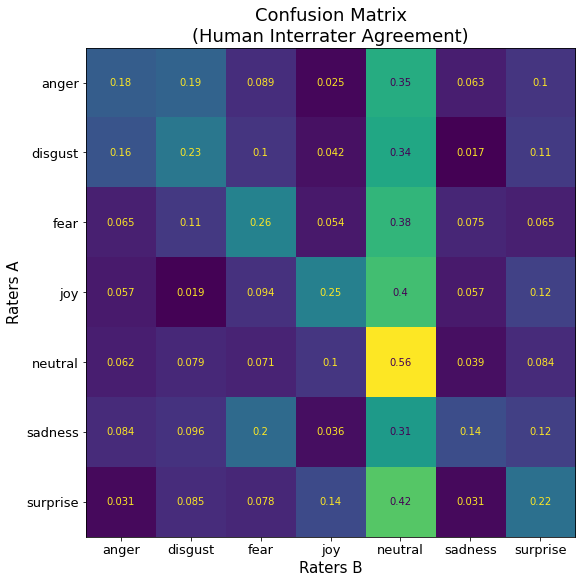

In [20]:
plt.figure(figsize=(5,5))

plt.rcParams["figure.figsize"] = [16,9]
cm=sklearn.metrics.confusion_matrix(ratersA,ratersB,
                                     normalize='true'
                                    )
cmd=sklearn.metrics.ConfusionMatrixDisplay(cm,display_labels=emotionToNumber.keys(),)
cmd.plot()
# cmd.im_.set_clim(0, 1)
cmd.im_.colorbar.remove()
plt.xticks(fontsize=13);plt.yticks(fontsize=13);
plt.xlabel("Raters B", fontsize=15); plt.ylabel("Raters A", fontsize=15)
plt.title("Confusion Matrix\n(Human Interrater Agreement)", fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('../manuscript/figures/sm/Human emotion annotations overlap.jpg',dpi=300,bbox_inches='tight',pad_inches=0.0)